**Import Neccesary Packages**

In [1]:
import pandas as pd 
import os
import cv2
import fnmatch
%matplotlib inline
import matplotlib.image as mpimg
import keras
from keras import backend as K
from keras.models import Sequential,load_model,Model
from keras.losses import binary_crossentropy
from keras.optimizers import Adam,RMSprop,Nadam
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input,SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks  import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.applications import VGG19,VGG16,ResNet50,Xception
import numpy as np
from keras.utils import np_utils
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


**To display some of the sample images**

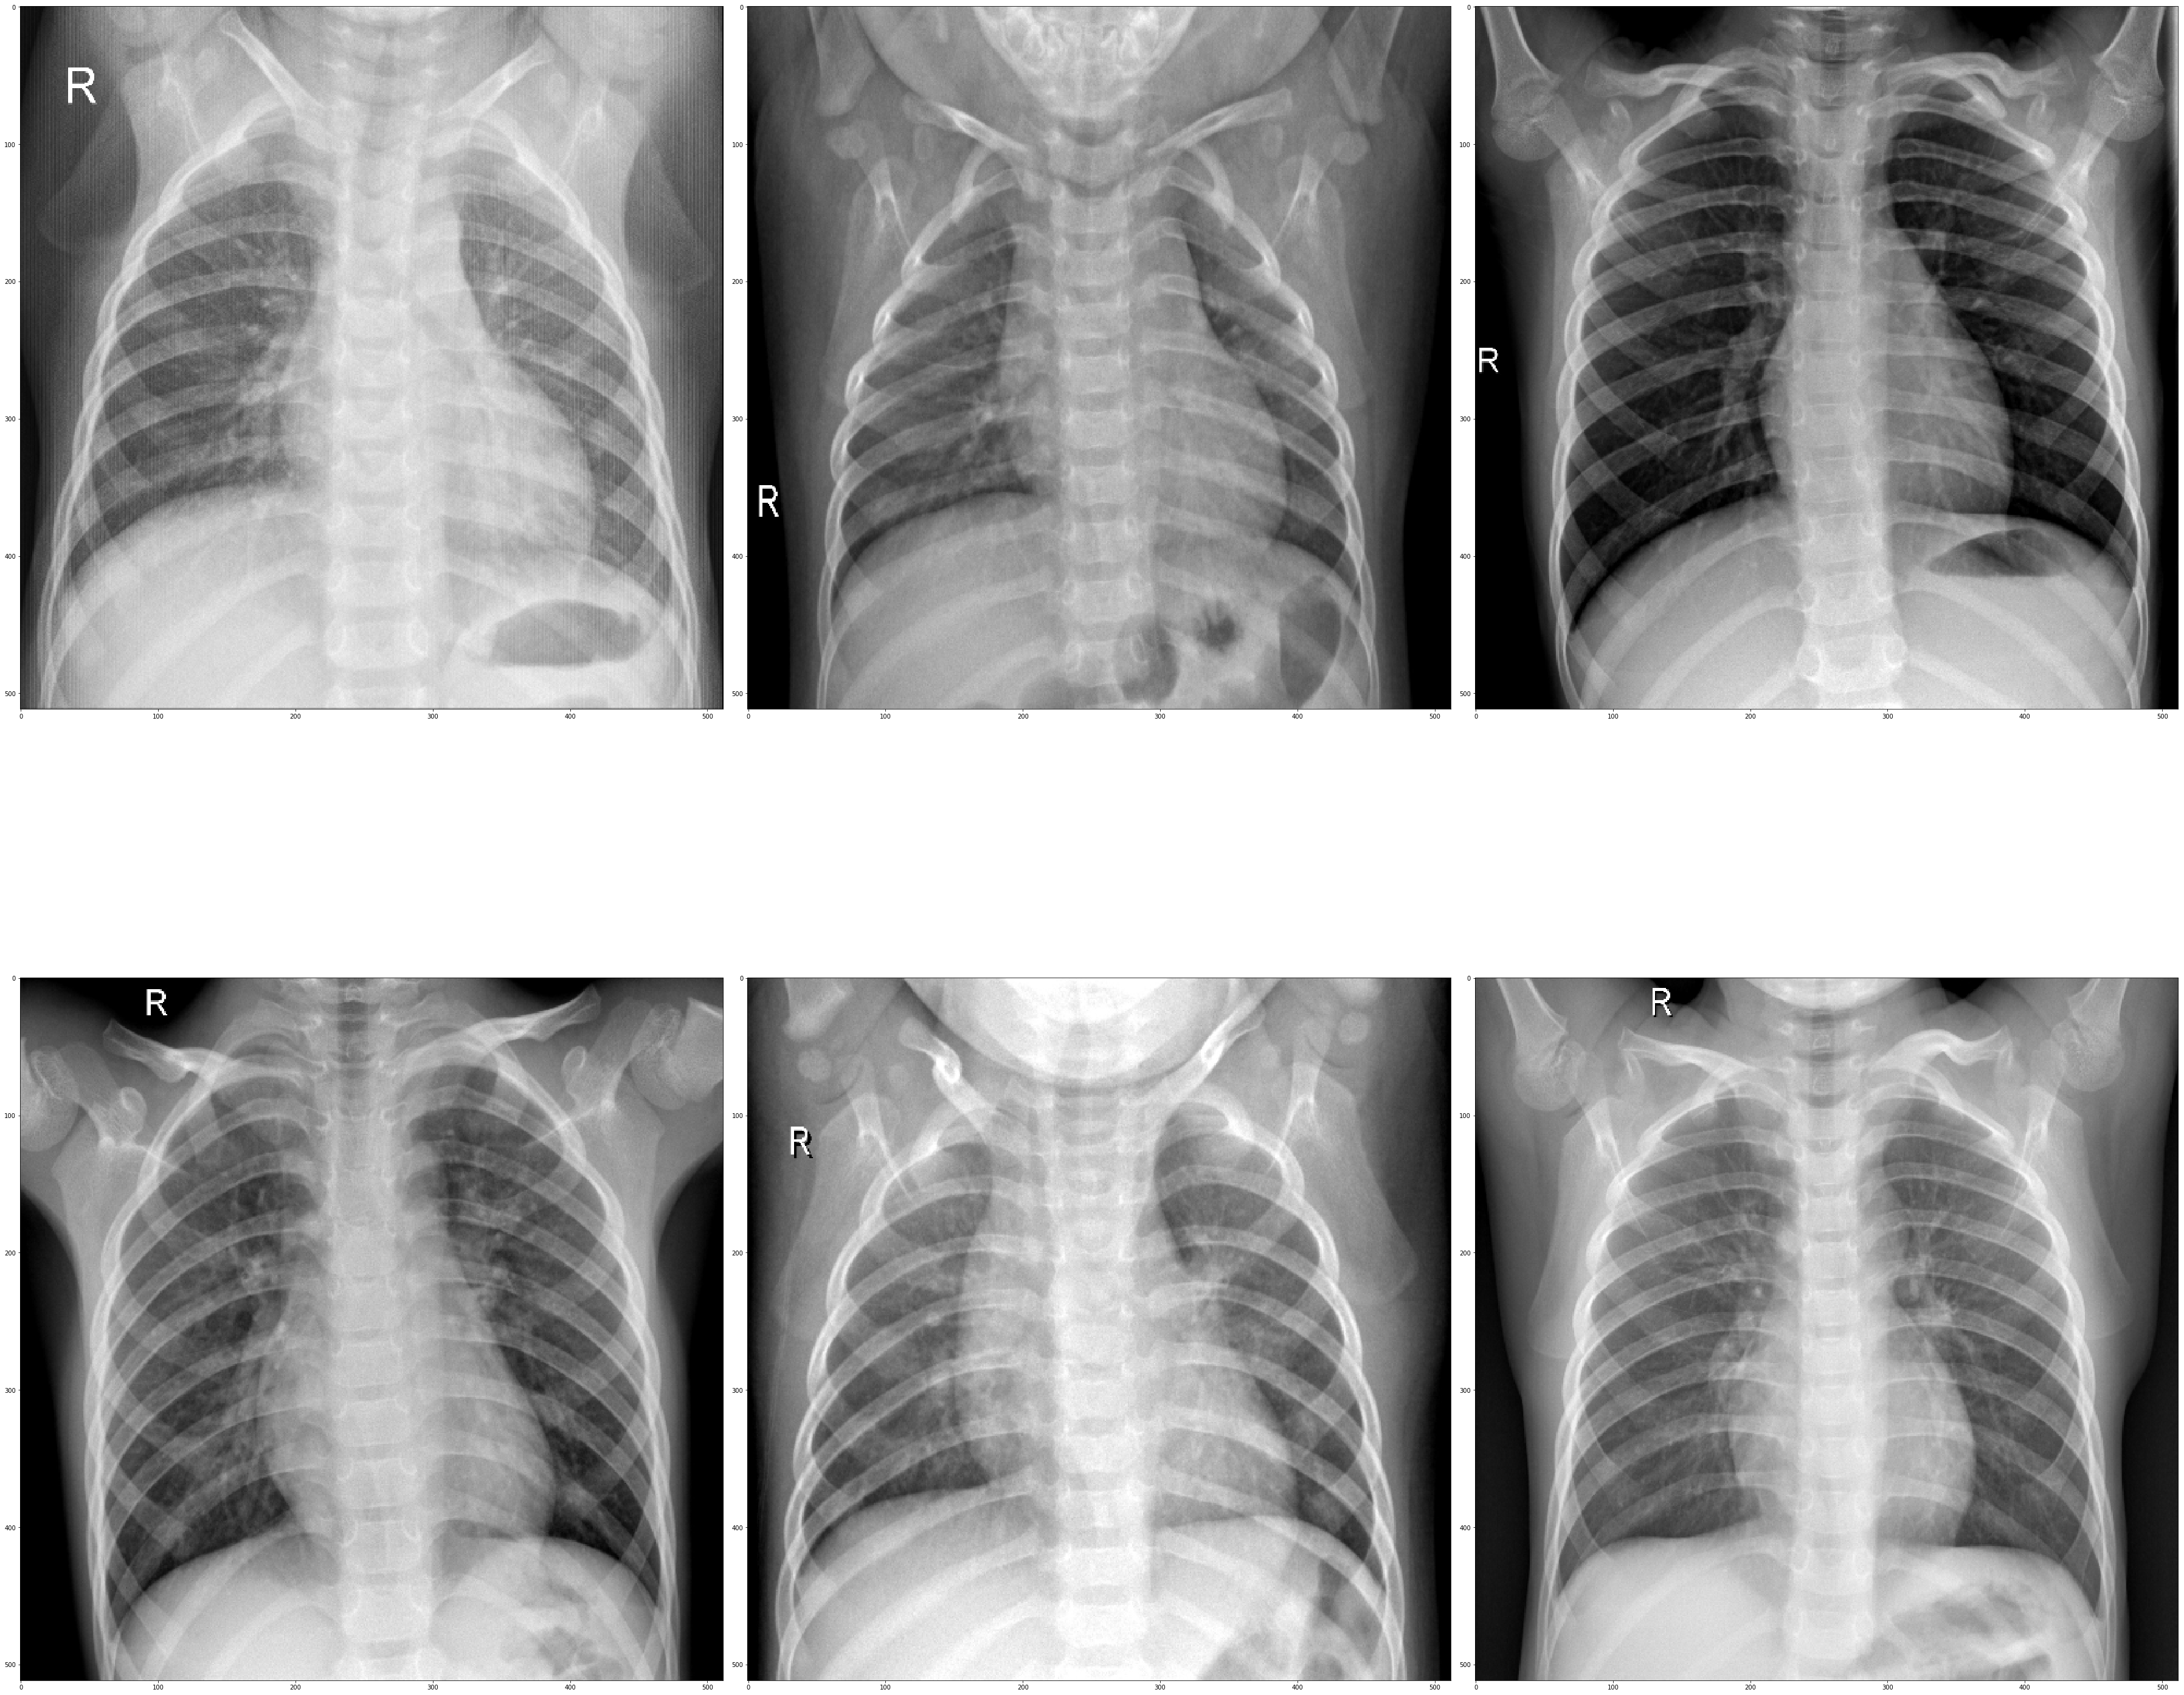

In [2]:
path='../input/chest_xray/chest_xray/train/NORMAL/'
i=0
plt.figure(figsize=(50, 50))
for root,dirs,files in os.walk(path):
    for f in files:
        if(i<6):
            plt.subplot(2, 3, i+1)
            image = cv2.imread(path+f)
            image = cv2.resize(image,(512,512))
            plt.imshow(image)
            i=i+1
        else:
            break
plt.tight_layout()
plt.show()

**To extract testing images in an array**

In [3]:
def test():
    x = []
    y = []
    path = "../input/chest_xray/chest_xray/test/NORMAL/"
    for root,dirs,files in os.walk(path):
        for f in files:
            if fnmatch.fnmatch(f,"*.jpeg"):
                img = cv2.imread(path+f)
                img = cv2.resize(img,(224,224))
                x.append(img)
                y.append(1)
    path = "../input/chest_xray/chest_xray/test/PNEUMONIA/"
    for root,dirs,files in os.walk(path):
        for f in files:
            if fnmatch.fnmatch(f,"*.jpeg"):
                img = cv2.imread(path+f)
                img = cv2.resize(img,(224,224))
                x.append(img)
                y.append(0)
    return np.array(x),np.array(y)

In [4]:
def valid():
    x = []
    y = []
    path = "../input/chest_xray/chest_xray/val/NORMAL/"
    for root,dirs,files in os.walk(path):
        for f in files:
            if fnmatch.fnmatch(f,"*.jpeg"):
                img = cv2.imread(path+f)
                img = cv2.resize(img,(224,224))
                x.append(img)
                y.append(1)
    path = "../input/chest_xray/chest_xray/val/PNEUMONIA/"
    for root,dirs,files in os.walk(path):
        for f in files:
            if fnmatch.fnmatch(f,"*.jpeg"):
                img = cv2.imread(path+f)
                img = cv2.resize(img,(224,224))
                x.append(img)
                y.append(0)
    return np.array(x),np.array(y)

In [5]:
def train():
    x = []
    y = []
    path = "../input/chest_xray/chest_xray/train/NORMAL/"
    for root,dirs,files in os.walk(path):
        for f in files:
            if fnmatch.fnmatch(f,"*.jpeg"):
                img = cv2.imread(path+f)
                img = cv2.resize(img,(224,224))
                x.append(img)
                y.append(1)
    path = "../input/chest_xray/chest_xray/train/PNEUMONIA/"
    for root,dirs,files in os.walk(path):
        for f in files:
            if fnmatch.fnmatch(f,"*.jpeg"):
                img = cv2.imread(path+f)
                img = cv2.resize(img,(224,224))
                x.append(img)
                y.append(0)
    return np.array(x),np.array(y)

In [6]:
valid_x,valid_y = valid()
train_x,train_y = train()

In [7]:
def model():
    image_input = Input(shape=(224,224, 3))
    model=ResNet50(weights='imagenet',include_top=True, input_tensor=image_input)
    last_layer = model.get_layer('fc1000').output
    #out = Dense(1000, activation='relu', name='fc10003')(last_layer)
    out = Dense(500, activation='relu', name='fc10002')(last_layer)
    out = Dense(100, activation='relu',name ='fc1001')(out)
    out = Dense(1, activation='sigmoid',name ='fc1003')(out)
    custom_model = Model(input=image_input,output=out)
    for layer in custom_model.layers[:-5]:
        layer.trainable = False
    
    return custom_model

In [8]:
model1 = model()
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
102858752/102853048 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  if __name__ == '__main__':


In [9]:
rt=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
weight_path="{}_weights.best.hdf5".format('Chest X-Ray Pneumonia')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model1.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [10]:
train_x,train_y = shuffle(train_x,train_y,random_state=0)
valid_x,valid_y = shuffle(valid_x, valid_y,random_state=0)
datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.05,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.05,horizontal_flip=True,vertical_flip=True,fill_mode="nearest")
datagen.fit(train_x)
history=model1.fit_generator(datagen.flow(train_x, train_y, batch_size=32),steps_per_epoch=len(train_x) // 32, epochs=15,validation_data=(train_x,train_y),verbose=1
                             ,callbacks=[rt,checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
163/163 [==============================] - 62s 379ms/step - loss: 0.2856 - acc: 0.8750 - val_loss: 0.2765 - val_acc: 0.8855

Epoch 00001: val_loss improved from inf to 0.27645, saving model to Chest X-Ray Pneumonia_weights.best.hdf5
Epoch 2/15
163/163 [==============================] - 55s 336ms/step - loss: 0.1536 - acc: 0.9465 - val_loss: 0.2173 - val_acc: 0.9128

Epoch 00002: val_loss improved from 0.27645 to 0.21725, saving model to Chest X-Ray Pneumonia_weights.best.hdf5
Epoch 3/15
163/163 [==============================] - 54s 334ms/step - loss: 0.1404 - acc: 0.9511 - val_loss: 0.3016 - val_acc: 0.8969

Epoch 00003: val_loss did not improve from 0.21725
Epoch 4/15
163/163 [==============================] - 56s 343ms/step - loss: 0.1340 - acc: 0.9511 - val_loss: 0.3879 - val_acc: 0.8767

Epoch 00004: val_loss did not improve from 0.21725
Epoch 5/15
163/163 [==============================] - 55s 340ms/step - loss: 0.1055 - 

**Save the weights of pretrained model**

In [11]:
model1.load_weights(weight_path)
model1.save('full_model.h5')

**Evaluate the model on Testing Data**

In [24]:
scores = model1.evaluate(test_x, test_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100)

624/624 [==============================] - 2s 3ms/step
Test loss: 0.6991373934687521
Test accuracy: 81.57051282051282


**Training vs Testing Loss Graph**

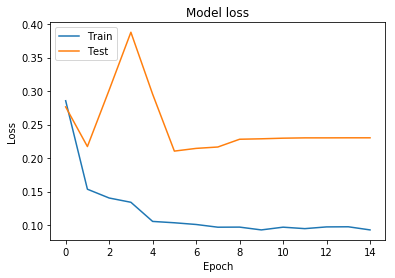

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()